In [1]:
#import packages
%matplotlib inline
import intake
import xarray as xr
import numpy as np
import util
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import pprint 
import warnings
warnings.simplefilter("ignore")
import iris
from eofs.iris import Eof

/Users/LukeAParsons/anaconda/envs/CMIP6-201910/lib/python3.7/site-packages/intake/source/discovery.py:136: FutureWarning: The drivers ['stac-catalog', 'stac-collection', 'stac-item'] do not specify entry_points and were only discovered via a package scan. This may break in a future release of intake. The packages should be updated.
  FutureWarning)


In [2]:
#define functions
def _compute_slope(y):
    """
    Private function to compute slopes at each grid cell using
    polyfit. 
    """
    x = np.arange(len(y))
    return np.polyfit(x, y, 1)[0] # return only the slope

def compute_slope(da):
    """
    Computes linear slope (m) at each grid cell.
    
    Args:
      da: xarray DataArray to compute slopes for
      
    Returns:
      xarray DataArray with slopes computed at each grid cell.
    """
    # apply_ufunc can apply a raw numpy function to a grid.
    # 
    # vectorize is only needed for functions that aren't already
    # vectorized. You don't need it for polyfit in theory, but it's
    # good to use when using things like np.cov.
    #
    # dask='parallelized' parallelizes this across dask chunks. It requires
    # an output_dtypes of the numpy array datatype coming out.
    #
    # input_core_dims should pass the dimension that is being *reduced* by this operation,
    # if one is being reduced.
    slopes = xr.apply_ufunc(_compute_slope,
                            da,
                            vectorize=True,
                            dask='parallelized', 
                            input_core_dims=[['time']],
                            output_dtypes=[float],
                            )
    return slopes

In [3]:
#Get your credit card and make a trip to the data store!
if util.is_ncar_host():
    col = intake.open_esm_datastore("../catalogs/glade-cmip6.json")
else:
    col = intake.open_esm_datastore("../catalogs/pangeo-cmip6.json")
col

pangeo-cmip6-ESM Collection with 28691 entries:
	> 10 activity_id(s)

	> 23 institution_id(s)

	> 48 source_id(s)

	> 29 experiment_id(s)

	> 86 member_id(s)

	> 23 table_id(s)

	> 190 variable_id(s)

	> 7 grid_label(s)

	> 28691 zstore(s)

	> 59 dcpp_init_year(s)

In [4]:
# shop around for which model, experiment, etc.
uni_dict = col.unique(['source_id', 'experiment_id', 'table_id'])

pprint.pprint(uni_dict, compact=True)

{'experiment_id': {'count': 29,
                   'values': ['ssp370', 'esm-ssp585', '1pctCO2-bgc', 'hist-bgc',
                              '1pctCO2', 'abrupt-4xCO2', 'historical',
                              'piControl', 'amip', 'esm-hist', 'esm-piControl',
                              'hist-GHG', 'hist-aer', 'hist-nat', 'dcppA-assim',
                              'dcppA-hindcast', 'dcppC-hindcast-noAgung',
                              'dcppC-hindcast-noElChichon',
                              'dcppC-hindcast-noPinatubo', 'highresSST-present',
                              'control-1950', 'hist-1950', 'deforest-globe',
                              'esm-ssp585-ssp126Lu', 'omip1', 'lgm', 'ssp126',
                              'ssp245', 'ssp585']},
 'source_id': {'count': 48,
               'values': ['BCC-ESM1', 'BCC-CSM2-MR', 'CanESM5', 'CNRM-ESM2-1',
                          'UKESM1-0-LL', 'GISS-E2-1-G', 'CESM2', 'GFDL-ESM4',
                          'AWI-CM-1-1-MR', 'CAM

In [5]:
# query which models/ensemble members have a certain type of experiment

models = set(uni_dict['source_id']['values']) # all the models

for experiment_id in ['historical']:
    query = dict(experiment_id=experiment_id, table_id='Amon', 
                 variable_id='ts')  
    #grid_label='gn'
    cat = col.search(**query)
    models = models.intersection({model for model in cat.df.source_id.unique().tolist()})

#models = models - {'CESM2-WACCM', 'CESM2'}

models = list(models)

In [6]:
#pick one specific model (trear yourself to a CESM2 for a change!)
cat = col.search(source_id=['CESM2'], experiment_id=['historical'], table_id='Amon', 
                 variable_id='ts')#, source_id=models
cat.df
dset_dict = cat.to_dataset_dict(zarr_kwargs={'consolidated': True, 'decode_times': False}, 
                                cdf_kwargs={'chunks': {}, 'decode_times': False})

--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'

--> There will be 1 group(s)


In [7]:
#define lat, lon, ens numbers, latitude and longitude for plotting later
dset_dict['CMIP.NCAR.CESM2.historical.Amon.gn']
members=dset_dict['CMIP.NCAR.CESM2.historical.Amon.gn'].member_id
ne=np.shape(members)
members[0].values
#print(members)
latshape=dset_dict['CMIP.NCAR.CESM2.historical.Amon.gn'].lat.shape
lonshape=dset_dict['CMIP.NCAR.CESM2.historical.Amon.gn'].lon.shape
ensshape=dset_dict['CMIP.NCAR.CESM2.historical.Amon.gn'].member_id.shape

longitude=dset_dict['CMIP.NCAR.CESM2.historical.Amon.gn'].lon
latitude=dset_dict['CMIP.NCAR.CESM2.historical.Amon.gn'].lat

In [8]:
# calculate linear trends (slopes) over the full time period

#pre-fill matrix w zeros that will be filled in for loop w values
slopes=np.zeros([192,288,11])

#loop through ensemble members (this took about 10 minutes) May God have mercy on your soul if the Kernel Goes Down
k=0
dset_dict['CMIP.NCAR.CESM2.historical.Amon.gn']
for e in members:
    # Just select CESM2 here for a single ensemble member.
    print(k)
    cat = col.search(member_id=members[k],
                 experiment_id='historical',
                 activity_id='CMIP',
                 table_id='Amon',
                 variable_id='ts',
                 grid_label='gn',
                 source_id='CESM2')

    # Chunk over the full time dimension since we're computing slope over the time dimension.
    dsets = cat.to_dataset_dict(cdf_kwargs={"chunks": {"time": -1}})
    ds = dsets['CMIP.NCAR.CESM2.historical.Amon.gn'].squeeze()
    #
    single_member = ds['ts'].load() # Load the single member INTO MEMORY.
    #
    slopes[:,:,k] = compute_slope(single_member)
    k=k+1

0
--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'

--> There will be 1 group(s)
1
--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'

--> There will be 1 group(s)
2
--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'

--> There will be 1 group(s)
3
--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'

--> There will be 1 group(s)
4
--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'

--> There will be 1 group(s)
5
--> The keys in the returned dictionary of datasets are constructed 

In [9]:
# for the trends: mean, max, min, differences from mean across ensemble members

ensemblemean = np.mean(slopes,2)

ensemblesigma = np.std(slopes,2)

ensemblecoeffvar = ensemblesigma/ensemblemean

ensemblemeantiles = np.repeat(ensemblemean[:,:,np.newaxis],11,axis=2)

ensembleanoms = slopes - ensemblemeantiles

ensemblemin = np.min(slopes,2)

ensemblemax = np.max(slopes,2)

In [10]:
#EOF/SVD of differences in trends (still trying to get this to work)
#ensembleanoms_reshaped = np.reshape(ensembleanoms, [192*288,11])
#ensembleanoms_reshaped.shape
#usv = np.linalg.svd(ensembleanoms_reshaped, full_matrices=True, compute_uv=True, hermitian=False)

0
1
2
3
4
5
6
7
8
9
10


Text(0.5, 0.98, 'CESM2 historical Linear ts Trends 1850-2014 CE')

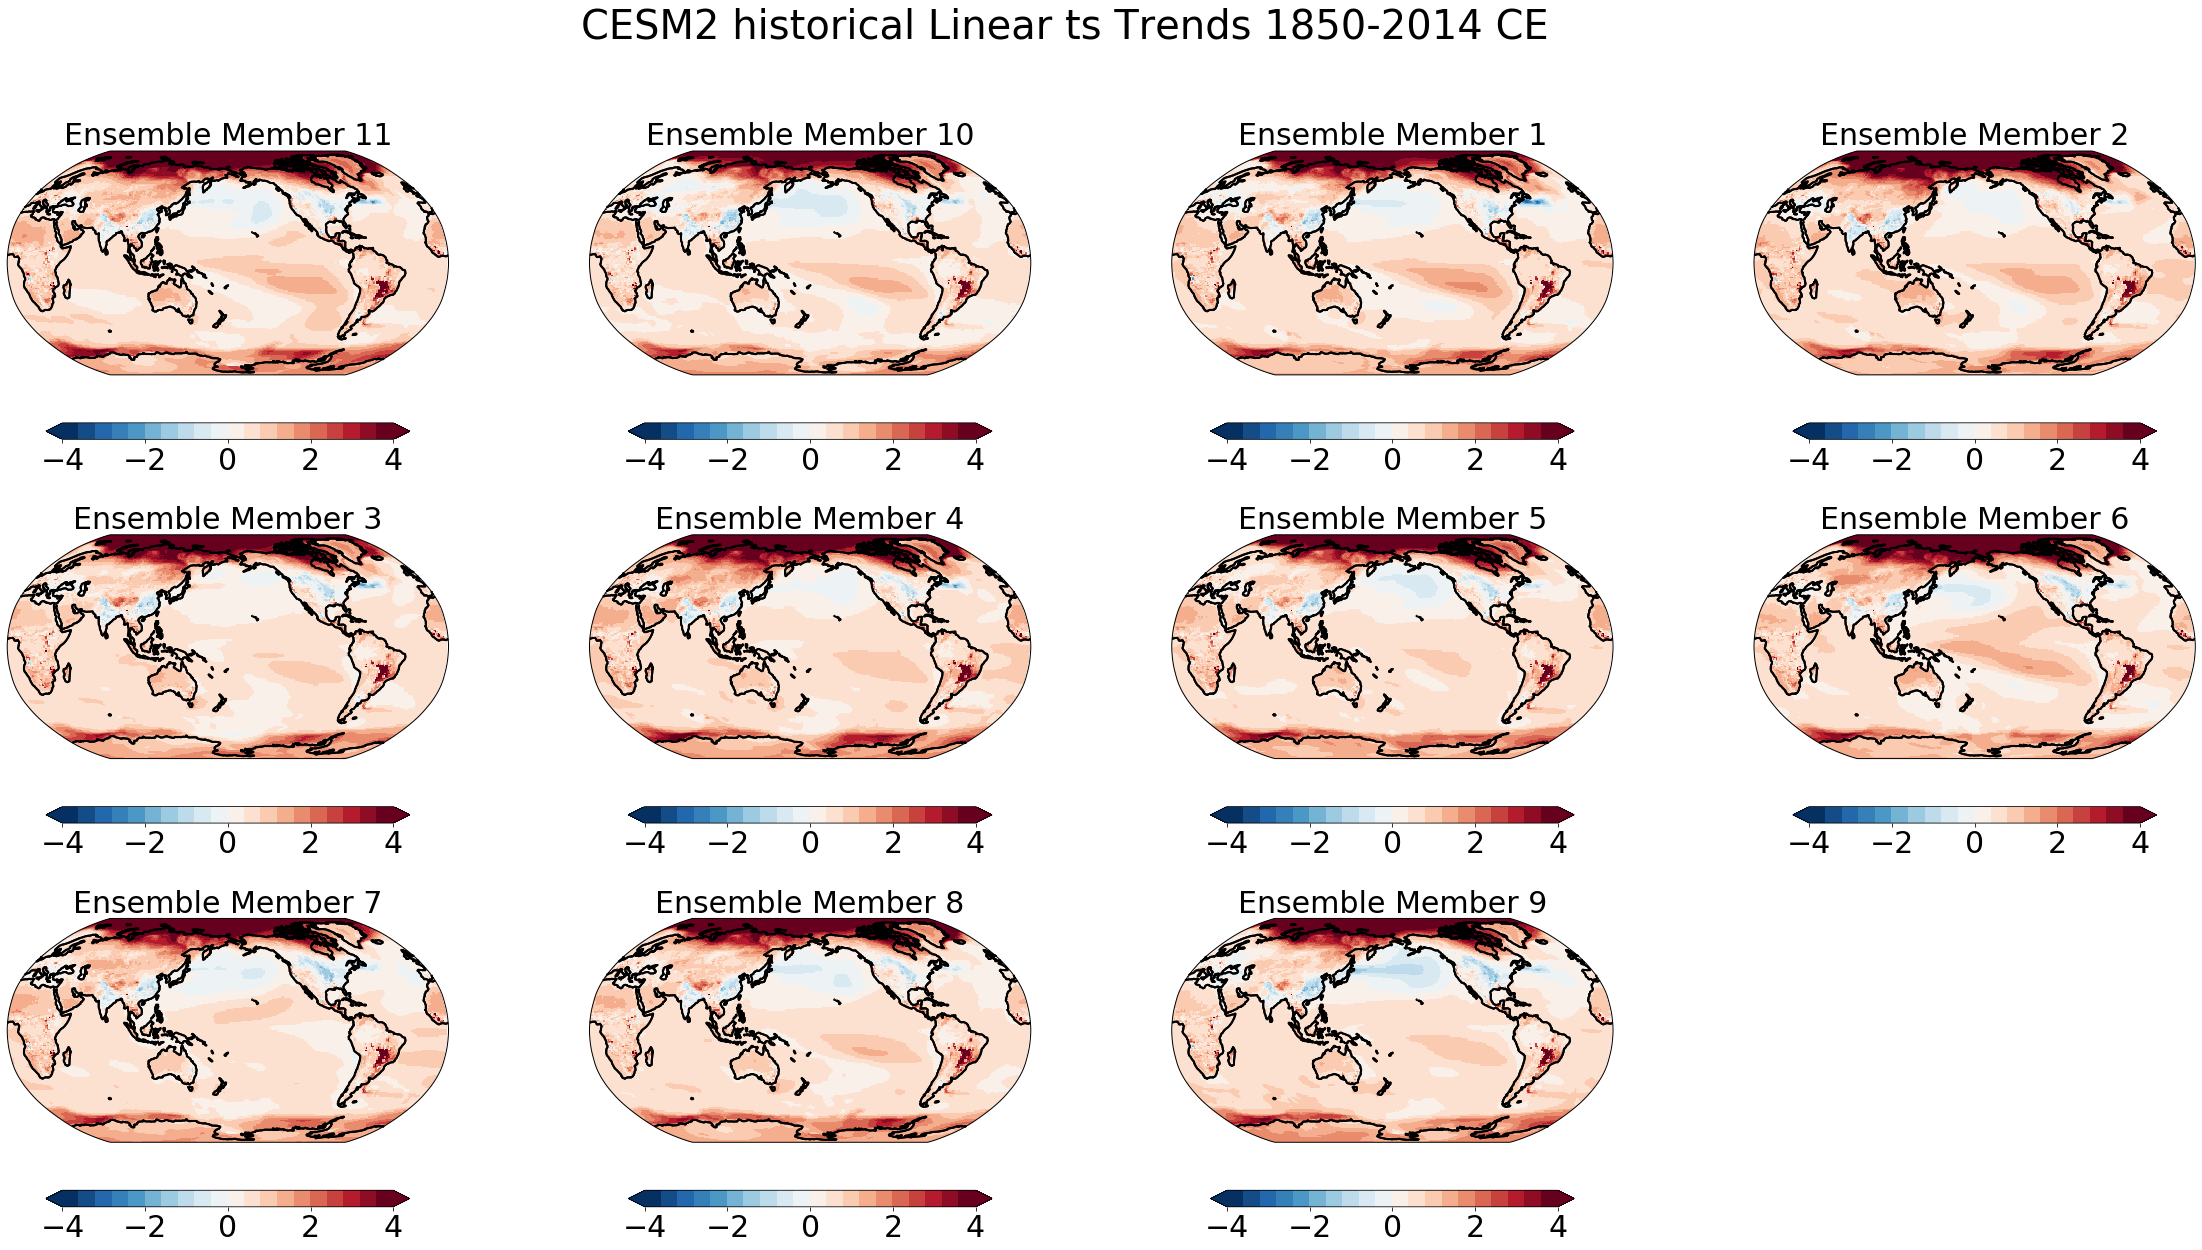

In [12]:
# plot the linear trends from individual ensemble members

#define data for plotting
mydata=np.squeeze(np.array(slopes))

fig = plt.figure(figsize=(40,20))
EnsembleMembers=(11,10,1,2,3,4,5,6,7,8,9)

k=0
for e in members:
    print(k)
    cat = col.search(member_id=members[k])
    # Make a plot
    ax = plt.subplot(3,4,k+1,projection = ccrs.Robinson(central_longitude=180))
    ax.set_global()
    ax.coastlines(resolution='110m', linewidth=2)
    plotvalue=mydata[:,:,k].dot(1980) #define data to be plotted - multiply by number of months
    plt.pcolormesh(longitude,latitude,plotvalue,cmap=plt.cm.get_cmap('RdBu_r',20),transform=ccrs.PlateCarree())
    cbar=plt.colorbar(extend='both',orientation='horizontal',shrink=0.75) #plot colorbar
    cbar.ax.tick_params(labelsize=30)
    plt.clim(-4, 4)
    #plt.title(np.str('Ensemble Member '),fontsize=30,ha='center')
    plt.title("Ensemble Member " + np.str(EnsembleMembers[k]),fontsize=30,ha='center')
    ax.coastlines(resolution='110m', linewidth=2)
    k = k+1
    
plt.suptitle('CESM2 historical Linear ts Trends 1850-2014 CE', fontsize=40)

#fig.savefig('CESM2_historical_ts_lineartrends_ensemble_members')

Text(0.5, 0.98, 'CESM2 historical Linear ts Trends 1850-2014 CE')

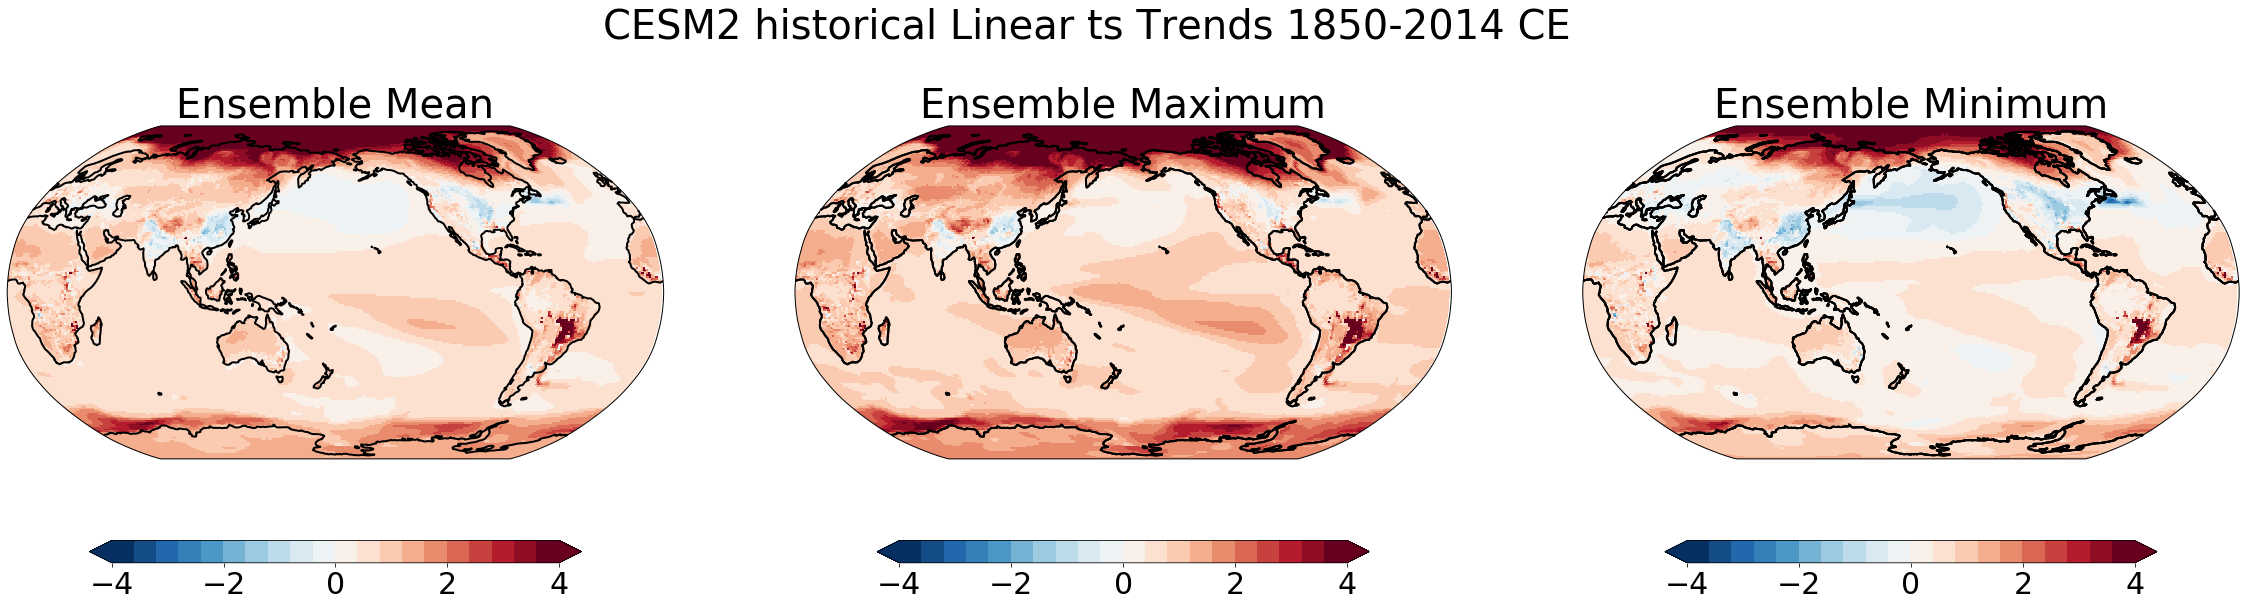

In [13]:
#plot ensemble mean, min, max

plt.figure(figsize=(40,10))
ax = plt.subplot(1,3,1,projection = ccrs.Robinson(central_longitude=180))
ax.set_global()
ax.coastlines(resolution='110m', linewidth=2)
plotvalue=ensemblemean.dot(1980) #define data to be plotted - multiply by number of months
plt.pcolormesh(longitude,latitude,plotvalue,cmap=plt.cm.get_cmap('RdBu_r',20),transform=ccrs.PlateCarree())
cbar=plt.colorbar(extend='both',orientation='horizontal',shrink=0.75) #plot colorbar
cbar.ax.tick_params(labelsize=30)
plt.clim(-4, 4);
plt.title(np.str('Ensemble Mean'),fontsize=40,ha='center')

ax = plt.subplot(1,3,2,projection = ccrs.Robinson(central_longitude=180))
ax.set_global()
ax.coastlines(resolution='110m', linewidth=2)
plotvalue=ensemblemax.dot(1980) #define data to be plotted - multiply by number of months
plt.pcolormesh(longitude,latitude,plotvalue,cmap=plt.cm.get_cmap('RdBu_r',20),transform=ccrs.PlateCarree())
cbar=plt.colorbar(extend='both',orientation='horizontal',shrink=0.75) #plot colorbar
cbar.ax.tick_params(labelsize=30)
plt.clim(-4, 4);
plt.title(np.str('Ensemble Maximum'),fontsize=40,ha='center')
ax.coastlines(resolution='110m', linewidth=2)

ax = plt.subplot(1,3,3,projection = ccrs.Robinson(central_longitude=180))
ax.set_global()
ax.coastlines(resolution='110m', linewidth=2)
ax.coastlines(resolution='110m', linewidth=2)
plotvalue=ensemblemin.dot(1980) #define data to be plotted - multiply by number of months
plt.pcolormesh(longitude,latitude,plotvalue,cmap=plt.cm.get_cmap('RdBu_r',20),transform=ccrs.PlateCarree())
cbar=plt.colorbar(extend='both',orientation='horizontal',shrink=0.75) #plot colorbar
cbar.ax.tick_params(labelsize=30)
plt.clim(-4, 4);
plt.title(np.str('Ensemble Minimum'),fontsize=40,ha='center')
ax.coastlines(resolution='110m', linewidth=2)

plt.suptitle('CESM2 historical Linear ts Trends 1850-2014 CE', fontsize=40)

#fig.savefig('CESM2_historical_ts_lineartrends_ensemble_mean_max_min')

Text(0.5, 0.98, 'CESM2 historical Linear ts Trends 1850-2014 CE')

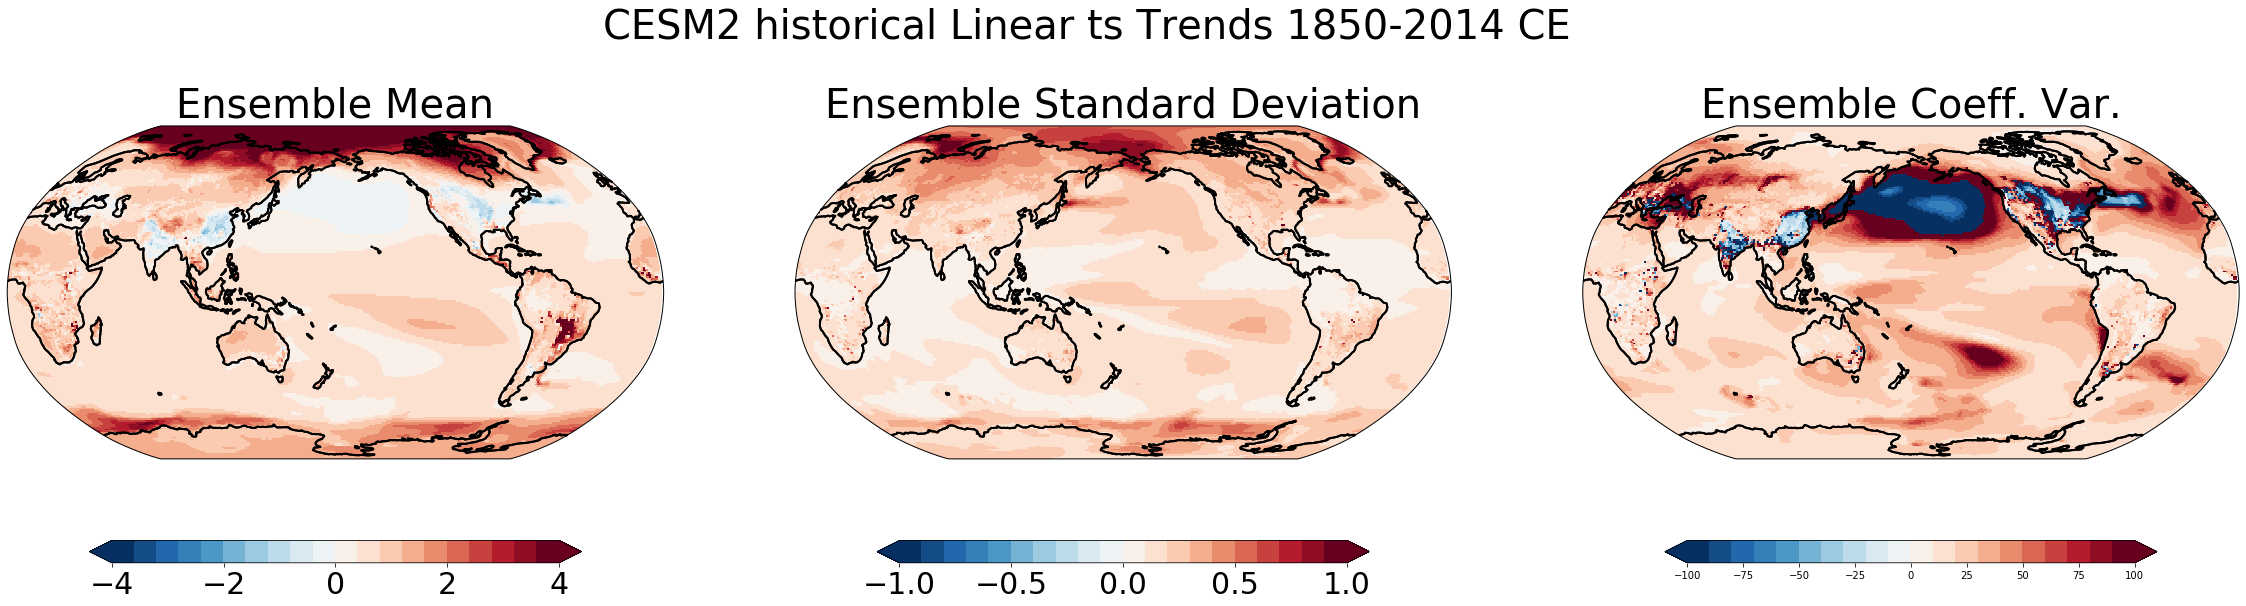

In [14]:
#plot ensemble mean, standard deviation of trends, and coefficient of variation of trends (%)

plt.figure(figsize=(40,10))
ax = plt.subplot(1,3,1,projection = ccrs.Robinson(central_longitude=180))
ax.set_global()
ax.coastlines(resolution='110m', linewidth=2)
plotvalue=ensemblemean.dot(1980) #define data to be plotted - multiply by number of months
plt.pcolormesh(longitude,latitude,plotvalue,cmap=plt.cm.get_cmap('RdBu_r',20),transform=ccrs.PlateCarree())
cbar=plt.colorbar(extend='both',orientation='horizontal',shrink=0.75) #plot colorbar
cbar.ax.tick_params(labelsize=30)
plt.clim(-4, 4);
plt.title(np.str('Ensemble Mean'),fontsize=40,ha='center')
ax.coastlines(resolution='110m', linewidth=2)

ax = plt.subplot(1,3,2,projection = ccrs.Robinson(central_longitude=180))
ax.set_global()
ax.coastlines(resolution='110m', linewidth=2)
plotvalue=ensemblesigma.dot(1980) #define data to be plotted - multiply by number of months
plt.pcolormesh(longitude,latitude,plotvalue,cmap=plt.cm.get_cmap('RdBu_r',20),transform=ccrs.PlateCarree())
cbar=plt.colorbar(extend='both',orientation='horizontal',shrink=0.75) #plot colorbar
cbar.ax.tick_params(labelsize=30)
plt.clim(-1, 1);
plt.title(np.str('Ensemble Standard Deviation'),fontsize=40,ha='center')
ax.coastlines(resolution='110m', linewidth=2)

ax = plt.subplot(1,3,3,projection = ccrs.Robinson(central_longitude=180))
ax.set_global()
ax.coastlines(resolution='110m', linewidth=2)
plotvalue=ensemblecoeffvar.dot(100) #define data to be plotted - multiply by number of months
plt.pcolormesh(longitude,latitude,plotvalue,cmap=plt.cm.get_cmap('RdBu_r',20),transform=ccrs.PlateCarree())
vcbar=plt.colorbar(extend='both',orientation='horizontal',shrink=0.75) #plot colorbar
cbar.ax.tick_params(labelsize=30)
plt.clim(-100, 100);
plt.title(np.str('Ensemble Coeff. Var.'),fontsize=40,ha='center')
ax.coastlines(resolution='110m', linewidth=2)

plt.suptitle('CESM2 historical Linear ts Trends 1850-2014 CE', fontsize=40)

#fig.savefig('CESM2_historical_ts_lineartrends_ensemble_mean_sigma_coeffvar')